In [2]:
import numpy as np
from skimage.feature import peak_local_max
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Defining the Harris corner detector function

In [3]:
def get_interest_points(image, feature_width, threshold=0.1, gaussians=(1, 2), min_distance=20, alpha=0.06):
    '''
    A vectorized version of harris corner detector.
    Inputs:
    image: numpy nd-array of dim (m, n, c) for RGB images or numpy nd-array of dim (m, n) for gray scale images
    feature_width: expected width of feature to determine Harris window width
    threshold: a value between 0 and 1 to determine the minimum threshold of the corner response value
    gaussians: tuple (sigma1, sigma2) where sigma1 is the sigma of the gaussian applied to the image,
               and sigma2 is the sigma of the gaussian applied to the derivatives
    min_distance: minimum number of pixels separating peaks and image boundary in nonmaximum suppression,
    alpha: constant used in corner response calculation
    Returns:
    x: numpy nd-array containing x coordinates of interest points
    y: numpy nd-array containing y coordinates of interest points
    '''
    
    if threshold <= 0 or threshold >= 1:  # raise error if threshold is outside range
        raise ValueError('threshold value must be between 0 and 1')
    
    if image.ndim == 3:  # if image is RGB convert it to gray
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
    sigma1, sigma2 = gaussians
    image = cv2.GaussianBlur(image, (3, 3), sigma1)  # apply gaussian blur to image
    Y, X = image.shape
    image = np.pad(image, (feature_width-1)//2, 'wrap')  # pad image
    # calculate x-derivative then apply gaussian blur
    Ix = cv2.GaussianBlur(cv2.Sobel(image,cv2.CV_64F,1,0,ksize=feature_width), (9, 9), sigma2)
    # calculate y-derivative then apply gaussian blur
    Iy = cv2.GaussianBlur(cv2.Sobel(image,cv2.CV_64F,0,1,ksize=feature_width), (9, 9), sigma2)
    # multiply Ix by Iy then divide result into series of sliding windows
    IxIy_win = np.lib.stride_tricks.as_strided(Ix*Iy, shape=(Y, X, feature_width, feature_width), strides=np.concatenate((Ix.strides, Ix.strides)))
    # sum each window
    IxIy_win = np.sum(IxIy_win, axis=(2, 3))
    # square Ix then divide result into series of sliding windows
    Ix2_win = np.lib.stride_tricks.as_strided(Ix**2, shape=(Y, X, feature_width, feature_width), strides=np.concatenate((Ix.strides, Ix.strides)))
    # sum each window
    Ix2_win = np.sum(Ix2_win, axis=(2, 3))
    # square Iy then divide result into series of sliding windows
    Iy2_win = np.lib.stride_tricks.as_strided(Iy**2, shape=(Y, X, feature_width, feature_width), strides=np.concatenate((Ix.strides, Ix.strides)))
    # sum each window
    Iy2_win = np.sum(Iy2_win, axis=(2, 3))
    # calculate corner response using det(H)-alpha*(trace(H))^2
    R = (Ix2_win*Iy2_win-IxIy_win**2) - alpha*((Ix2_win+Iy2_win)**2)
    R[R < threshold*np.max(R)] = 0  # suppress any R value below threshold
    points = peak_local_max(R, min_distance=min_distance)  # apply nonmaximum suppression
    return points[:, 1], points[:, 0]

## Defining a helper function to visualize the corners detected by Harris detector

In [7]:
def draw_corners(image, x, y, corner_width):
    '''
    Visualization function to draw corners on image.
    Inputs:
    image: numpy nd-array of dim (m, n, c) for RGB images or numpy nd-array of dim (m, n) for gray scale images
    x: numpy nd-array containing x coordinates of interest points
    y: numpy nd-array containing y coordinates of interest points
    corner_wdith: width of square to draw on the corner
    Returns:
    image_corners: numpy nd-array of dim (m, n, c) containing the image with the corners drawn on it as squares
    '''
    if image.ndim != 3:  # if image is grayscale, make a new RGB copy
        image_corners = cv2.cvtColor(image ,cv2.COLOR_GRAY2RGB)
    else:  #  otherwise just make a copy
        image_corners = image.copy()
        
    for x, y in list(zip(x, y)):  # loop over all points and draw a red square around them
        image_corners[y - (corner_width-1)//2 : y + 1 + (corner_width-1)//2,
                           x - (corner_width-1)//2 : x + 1 + (corner_width-1)//2, 0] = 255
        image_corners[y - (corner_width-1)//2 : y + 1 + (corner_width-1)//2,
                           x - (corner_width-1)//2 : x + 1 + (corner_width-1)//2, 1] = 0
        image_corners[y - (corner_width-1)//2 : y + 1 + (corner_width-1)//2,
                           x - (corner_width-1)//2 : x + 1 + (corner_width-1)//2, 2] = 0
    return image_corners

## Loading the image

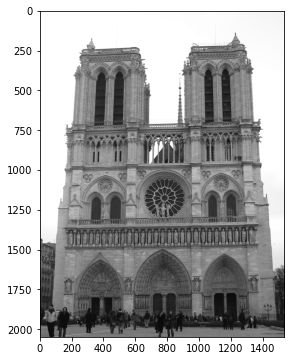

In [5]:
image = cv2.imread('NotreDame1.jpg', cv2.IMREAD_GRAYSCALE)
figure(figsize=(6,6))
plt.imshow(image, cmap='gray')

## Testing the function with default parameters

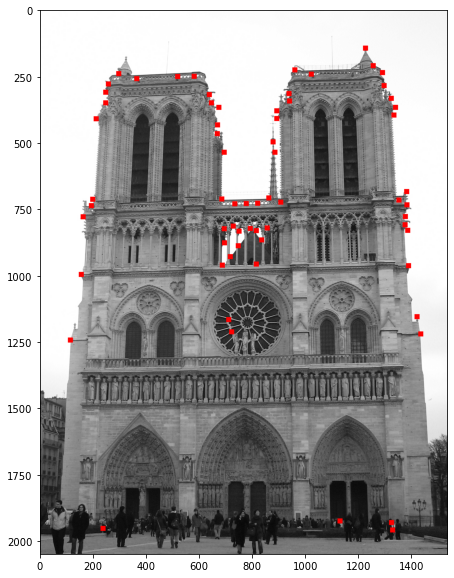

In [10]:
x, y = get_interest_points(image, 5)
figure(figsize=(10,10))
plt.imshow(draw_corners(image, x, y, 20))